# Visualize predicted dates

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sys, scipy
from   scipy.spatial import distance
from   scipy.stats import gaussian_kde
from   itertools import combinations

In [2]:
# function to prepare and calculate JSD from input data

def calculate_js_distance(data1, data2, num_points=1000):
    '''Calculate the Jensen-Shannon DISTANCE between two datasets.
    Takes two Pandas series, calculates KDE of each, normalizes, and
      calculates JSD via SciPy over num_points grid. Returns JSD.
    Note that JS distance = sqrt(JS divergence)
    '''
    # Create kernel density estimates
    kde1 = gaussian_kde(data1)
    kde2 = gaussian_kde(data2)
    
    # Create a common evaluation grid
    x_min = min(data1.min(), data2.min())
    x_max = max(data1.max(), data2.max())
    x_grid = np.linspace(x_min, x_max, num_points)
    
    # Calculate probability densities on the grid
    p = kde1(x_grid)
    q = kde2(x_grid)
    
    # Normalize to ensure they're proper probability distributions
    p = p / np.sum(p)
    q = q / np.sum(q)

    # Calculate Jensen-Shannon divergence
    js_distance = distance.jensenshannon(p, q)
    
    return js_distance

In [3]:
gpt35 = pd.read_csv('GPT35_publicationyears.tsv', sep='\t')

In [4]:
gpt35.head()

,text,label,prediction
0,"On the contrary, he argues that the Teutonic t...",1,1996.4344
1,For a quarter of a century this firm has stood...,1,1933.0599
2,It is important to remember that the purpose o...,1,1997.6356
3,"Hence, by utilizing Euler's formulae, we can f...",1,2001.2347
4,"""You jest make it good an' heavy an' pufFon th...",0,1911.4178


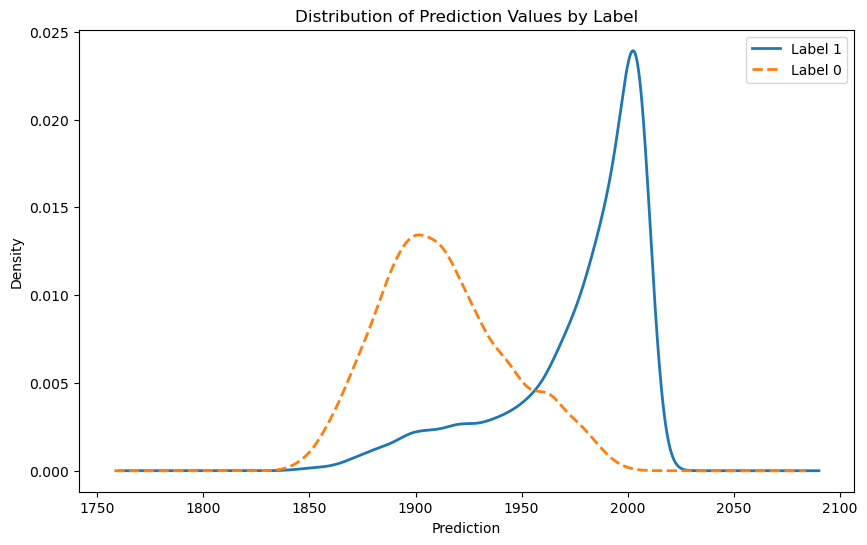

In [5]:
# Separate the dataframe into two subsets
gpt35_label_1 = gpt35[gpt35['label'] == 1]
gpt35_label_0 = gpt35[gpt35['label'] == 0]

# Plot the distribution of 'prediction' values using KDE
plt.figure(figsize=(10, 6))
gpt35_label_1['prediction'].plot(kind='kde', label='Label 1', linestyle='-', linewidth=2)
gpt35_label_0['prediction'].plot(kind='kde', label='Label 0', linestyle='--', linewidth=2)

# Add title and labels
plt.title('Distribution of Prediction Values by Label')
plt.xlabel('Prediction')
plt.ylabel('Density')
plt.legend()
plt.show()

In [6]:
gpt35 = gpt35_label_1
groundtruth = gpt35_label_0

In [7]:
gpt4o = pd.read_csv('GPT4o_publicationyears.tsv', sep='\t')

In [8]:
gpt1914 = pd.read_csv('GPT1914_publicationyears.tsv', sep='\t')

In [9]:
gpt1914 = gpt1914[gpt1914['label'] == 1]

In [10]:
finetune = pd.read_csv('finetuned_4omini_publicationyears.tsv', sep='\t')

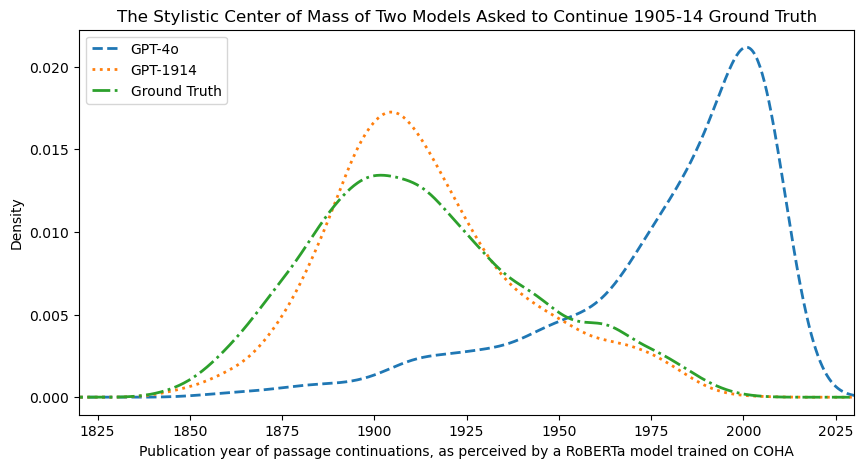

In [11]:
# We plot kernel density estimates of the publication years of all four datasets:
# the GPT-3.5 dataset, the GPT-4o dataset, the GPT-1914 dataset, and the ground truth dataset.
# Since real publication years don't extend below 1850 or above 2020, we limit the x-axis to this range.

plt.figure(figsize=(10, 5))
# gpt35['prediction'].plot(kind='kde', label='GPT-3.5', linestyle='-', linewidth=2)
# finetune['prediction'].plot(kind='kde', label='GPT-4o (fine-tuned)', linestyle='-', linewidth=2)
gpt4o['prediction'].plot(kind='kde', label='GPT-4o', linestyle='--', linewidth=2)
gpt1914['prediction'].plot(kind='kde', label='GPT-1914', linestyle=':', linewidth=2)
groundtruth['prediction'].plot(kind='kde', label='Ground Truth', linestyle='-.', linewidth=2)

plt.xlim(1820, 2030)
plt.title('The Stylistic Center of Mass of Two Models Asked to Continue 1905-14 Ground Truth')
plt.xlabel('Publication year of passage continuations, as perceived by a RoBERTa model trained on COHA')
plt.ylabel('Density')
plt.legend()

# We export the plot to a file using bbox_inches='tight' to ensure that the legend is not cut off.
plt.savefig('stylistic_center_of_mass.png', bbox_inches='tight', dpi=300)

plt.show()


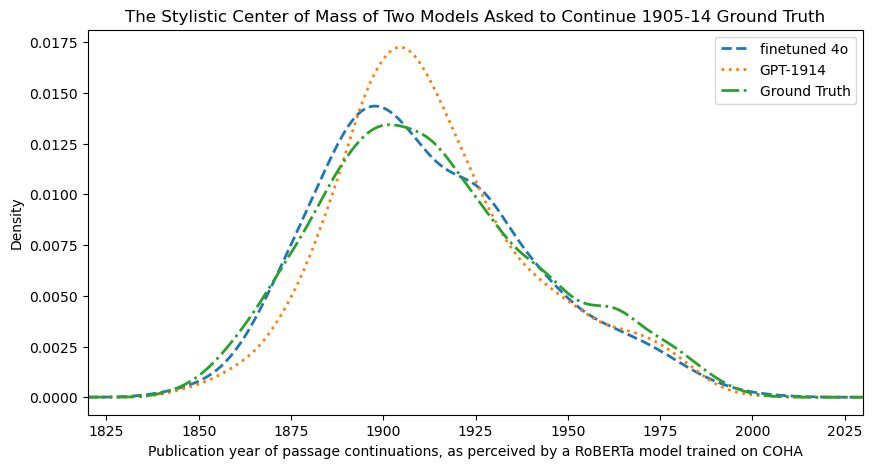

In [12]:
# We plot kernel density estimates of the publication years of all four datasets:
# the GPT-3.5 dataset, the GPT-4o dataset, the GPT-1914 dataset, and the ground truth dataset.
# Since real publication years don't extend below 1850 or above 2020, we limit the x-axis to this range.

plt.figure(figsize=(10, 5))
# gpt35['prediction'].plot(kind='kde', label='GPT-3.5', linestyle='-', linewidth=2)
# finetune['prediction'].plot(kind='kde', label='GPT-4o (fine-tuned)', linestyle='-', linewidth=2)
finetune['prediction'].plot(kind='kde', label='finetuned 4o', linestyle='--', linewidth=2)
gpt1914['prediction'].plot(kind='kde', label='GPT-1914', linestyle=':', linewidth=2)
groundtruth['prediction'].plot(kind='kde', label='Ground Truth', linestyle='-.', linewidth=2)

plt.xlim(1820, 2030)
plt.title('The Stylistic Center of Mass of Two Models Asked to Continue 1905-14 Ground Truth')
plt.xlabel('Publication year of passage continuations, as perceived by a RoBERTa model trained on COHA')
plt.ylabel('Density')
plt.legend()

# We export the plot to a file using bbox_inches='tight' to ensure that the legend is not cut off.
plt.savefig('finetuned_center_of_mass.png', bbox_inches='tight', dpi=300)

plt.show()


In [13]:
# calculate Jensen-Shannon distance over all pairs of data
jsd_data = {
    'GPT-3.5':      gpt35['prediction'],
    'GPT-1914':     gpt1914['prediction'],
    'GPT-4o':       gpt4o['prediction'],
    'Finetune':     finetune['prediction'],
    'Ground truth': groundtruth['prediction']
}

d1 = []
d2 = []
jsd = []
for i, j in combinations(jsd_data.keys(), r=2):
    d1.append(i)
    d2.append(j)
    jsd.append(calculate_js_distance(jsd_data[i], jsd_data[j]))

jsds = pd.DataFrame(
    {
        'Data 1':d1,
        'Data 2':d2,
        'JS dist':jsd
    }
)
jsds['JS div'] = jsds['JS dist']**2

print('JSD, smallest to largest')
jsds.sort_values(by='JS dist')

JSD, smallest to largest


,Data 1,Data 2,JS dist,JS div
9,Finetune,Ground truth,0.039696,0.001576
1,GPT-3.5,GPT-4o,0.054612,0.002982
5,GPT-1914,Finetune,0.074385,0.005533
6,GPT-1914,Ground truth,0.078497,0.006162
3,GPT-3.5,Ground truth,0.540478,0.292116
2,GPT-3.5,Finetune,0.552715,0.305494
0,GPT-3.5,GPT-1914,0.555211,0.308259
8,GPT-4o,Ground truth,0.557198,0.310470
7,GPT-4o,Finetune,0.570522,0.325495
4,GPT-1914,GPT-4o,0.572158,0.327364


In [14]:
print('JSD relative to ground truth')
jsds.loc[jsds['Data 2']=='Ground truth'].sort_values(by=['Data 2', 'JS dist'])

JSD relative to ground truth


,Data 1,Data 2,JS dist,JS div
9,Finetune,Ground truth,0.039696,0.001576
6,GPT-1914,Ground truth,0.078497,0.006162
3,GPT-3.5,Ground truth,0.540478,0.292116
8,GPT-4o,Ground truth,0.557198,0.310470
